In [1]:
import numpyro
numpyro.enable_x64()
# numpyro.set_platform('gpu')

import jax
print(jax.devices())

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value, init_to_sample, Trace_ELBO, TraceGraph_ELBO

from numpyro.infer.svi import SVI
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoLaplaceApproximation, AutoDAIS, AutoBNAFNormal, AutoIAFNormal, AutoMultivariateNormal
from numpyro.optim import Adam, ClippedAdam

import tensorflow_probability.substrates.jax as tfp

from jax import numpy as jnp
from jax import random, vmap

import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns

import siuba as s
from siuba import _

from plotnine import *

from matplotlib import pyplot as plt

import pickle

from lib.helpers import *
from lib.models import *

[GpuDevice(id=0, process_index=0)]


In [2]:
## Define functions

def fit_svi(model, x_data, y_data, optimizer=Adam(1e-3), loss=TraceGraph_ELBO(), n_steps=10_000, full_rank = False, filename=None, **kwargs):
    if full_rank:
        guide = AutoMultivariateNormal(model, **kwargs)
    else:
        guide = AutoNormal(model, **kwargs)

    if filename is not None and os.path.exists(filename):
        result = pickle.load(open(filename, "rb"))
        return result
    else:
        svi = SVI(model, guide, optimizer, loss)
        result = svi.run(random.PRNGKey(1), n_steps, x_data, y_data)
        output = {"params": result.params, "guide": guide, "losses": result.losses}

        if filename is not None:
            pickle.dump(output, open(filename, "wb"))

        return(output)


def arviz_from_svi(model, guide, params, *args, obs_data=None, num_samples = 1_000, filename=None):
    
    if filename is not None and os.path.exists(filename):
        result = pickle.load(open(filename, "rb"))
        return result
    
    else:
        
        posterior_samples = guide.sample_posterior(random.PRNGKey(1), params=params, sample_shape=(num_samples,))
        samples_posterior_predictive = Predictive(model=model, posterior_samples=posterior_samples)(random.PRNGKey(1), *args)
        samples_prior_predictive = Predictive(model=model, params=None, num_samples=num_samples)(random.PRNGKey(2), *args)

        ll_dict = numpyro.infer.util.log_likelihood(model, posterior_samples, *args, obs_data)
        data = {}
        for obs_name, log_like in ll_dict.items(): # don't think this is necessary but just to be safe ...
            shape = (1, len(log_like)) + log_like.shape[1:]
            data[obs_name] = np.reshape(log_like.copy(), shape)

        result = az.from_dict(
            {k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
            prior = {k: np.expand_dims(v, 0) for k, v in samples_prior_predictive.items()},
            posterior_predictive = {k: np.expand_dims(v, 0) for k, v in samples_posterior_predictive.items()},
            log_likelihood = data,
            observed_data = {"yhat": obs_data}
        )
        
        if filename is not None:
            pickle.dump(result, open(filename, "wb"))
        
        return(result)
        

In [3]:
## Load Experiment 1 data
df1 = load_data_exp1() 
df1 = df1[~df1.querytype.str.contains('or')] # filtering as in avg analyses
df1 = (df1 >>
    s.arrange(_.ID) >>
    s.mutate(block = _.block-1) >> 
      s.mutate(estimate =  np.round(_.estimate*20).astype("int64"))
)

X_exp1, y_exp1 = make_model_data(df1)
print(len(y_exp1), "observations")


5664 observations


<AxesSubplot:xlabel='estimate'>

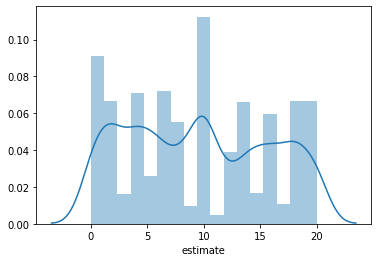

In [4]:
sns.distplot(df1.estimate)

In [5]:
## Load Experiment 2 data

df2 = (load_data_exp2_trials()  >> 
        s.filter(_.condition!=2) >>
      s.mutate(block = _.block-1) >> 
      s.mutate(estimate =  np.round(_.estimate*20).astype("int64"))
     )

X_exp2, y_exp2 = make_model_data(df2)
print(len(y_exp2), "observations")

10080 observations


<AxesSubplot:xlabel='estimate'>

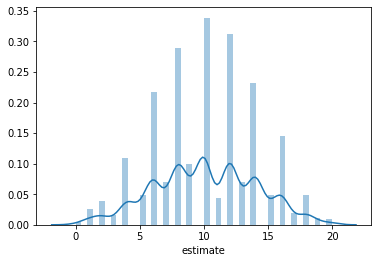

In [6]:
sns.distplot(df2.estimate)

## Experiment 1 - Bayesian Sampler

In [7]:
from jax.example_libraries import optimizers

# lr = optimizers.exponential_decay(5e-4, 1000, .85)

res_bs_exp1 = fit_svi(
    bs_complex_mlm_trial_level, 
    X_exp1, 
    y_exp1,
    optimizer = ClippedAdam(3.5e-4, clip_norm=1., b1=.95), # very finnicky 2.5e-4 worked
    loss = TraceGraph_ELBO(num_particles=2), # refit
    n_steps = 25_000, 
    full_rank = True,
    filename = "local/svi-bs_complex_mlm_trial_level-exp1-25k.p"
)

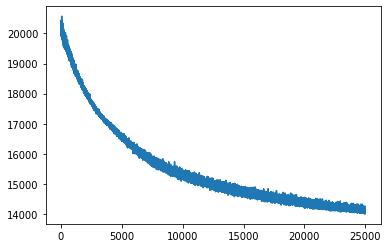

In [8]:
from matplotlib import pyplot as plt
plt.plot(res_bs_exp1["losses"])

In [9]:
az_bs_exp1 = arviz_from_svi(
    bs_complex_mlm_trial_level, 
    res_bs_exp1["guide"], 
    res_bs_exp1["params"], 
    X_exp1, 
    obs_data=y_exp1,
    filename = "local/az-bs_complex_mlm_trial_level-exp1svi.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

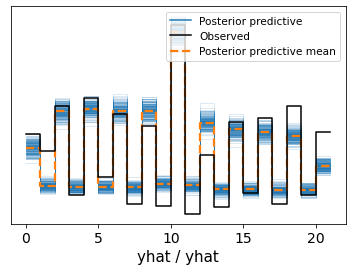

In [10]:
az.plot_ppc(az_bs_exp1, num_pp_samples=200)

In [11]:
az_bs_exp1.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.34127031, 0.15323861, 0.50549108]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

In [12]:
res_bs_exp1_varyN = fit_svi(
    bs_complex_mlm_trial_level_varyN, 
    X_exp1, 
    y_exp1,
    optimizer = ClippedAdam(1e-3, clip_norm=1., b1=.95), # very finnicky 2.5e-4 worked
    loss = TraceGraph_ELBO(num_particles=2), # refit
    n_steps = 5_000, 
    full_rank = True,
    filename = "local/svi-bs_complex_mlm_trial_level-exp1-varyingN.p"
)

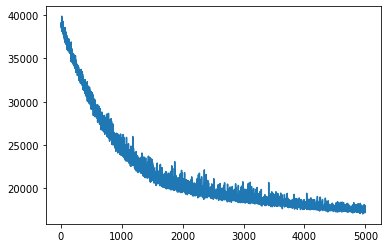

In [13]:
plt.plot(res_bs_exp1_varyN["losses"])

In [14]:
az_bs_exp1_varyN = arviz_from_svi(
    bs_complex_mlm_trial_level, 
    res_bs_exp1["guide"], 
    res_bs_exp1["params"], 
    X_exp1, 
    obs_data=y_exp1,
    filename = "local/az-bs_complex_mlm_trial_level-exp1svi-varyingN.p"
)

In [15]:
az_bs_exp1_varyN.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.28389985, 0.1754665 , 0.54063365]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

## Experiment 1 - PT+N

In [16]:
res_ptn_exp1 = fit_svi(
    ptn_simplecond_mlm_trial_level_disc2, 
    X_exp1, 
    y_exp1,
    optimizer = Adam(1e-3),
    n_steps = 10_000,
    full_rank=True,
    filename="local/svi-ptn_simplecond_mlm_trial_level_disc-exp1.p"
)

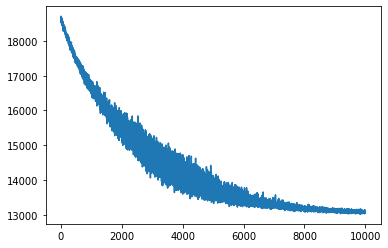

In [17]:
plt.plot(res_ptn_exp1["losses"])

In [18]:
az_ptn_exp1 = arviz_from_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    res_ptn_exp1["guide"], 
    res_ptn_exp1["params"], 
    X_exp1, 
    obs_data=y_exp1,
    filename = "local/az-ptn_simplecond_mlm_trial_level_disc-exp1svi.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

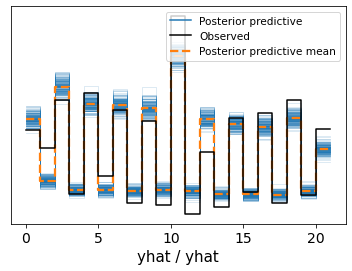

In [19]:
az.plot_ppc(az_ptn_exp1, num_pp_samples=200)

In [20]:
az_ptn_exp1.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.14450024, 0.2923612 , 0.56313855]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

### Model comparison

In [21]:
az.compare({"bs": az_bs_exp1, "bs-varying": az_bs_exp1_varyN, "ptn":az_ptn_exp1})

/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated sha

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ptn,0,-12406.406816,566.455101,0.000000,0.889633,92.927960,0.000000,True,log
bs-varying,1,-13814.205563,1117.657965,1407.798747,0.012019,85.305073,65.544387,True,log
bs,2,-13917.918956,999.146138,1511.512140,0.098348,85.590374,71.650365,True,log


## Experiment 2 - Bayesian Sampler

In [22]:
res_bs_exp2 = fit_svi(
    bs_complex_mlm_trial_level, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(1e-3),
    loss = TraceGraph_ELBO(num_particles=4),
    n_steps = 5_000,
    full_rank=True,
    filename="local/svi-bs_complex_mlm_trial_level-exp2.p"
)

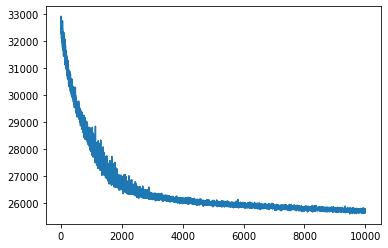

In [23]:
from matplotlib import pyplot as plt
plt.plot(res_bs_exp2["losses"])

In [24]:
az_bs_exp2 = arviz_from_svi(
    bs_complex_mlm_trial_level, 
    res_bs_exp2["guide"], 
    res_bs_exp2["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-bs_complex_mlm_trial_level-exp2svi.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

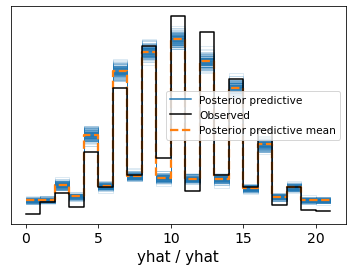

In [25]:
az.plot_ppc(az_bs_exp2, num_pp_samples=200)

In [26]:
az_bs_exp2.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.25145303, 0.1949195 , 0.55362746]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

### allowing N to vary

In principle could be another way for the BS model to accommodate the data. Helps a bit but PT+N still wins.

In [27]:
res_bs_exp2_varyN = fit_svi(
    bs_complex_mlm_trial_level_varyN, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(1e-3),
    loss = TraceGraph_ELBO(num_particles=4),
    n_steps = 5_000,
    full_rank=True,
    filename="local/svi-bs_complex_mlm_trial_level-exp2-varyingN.p"
)

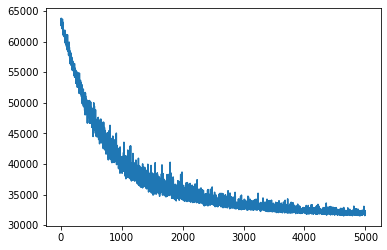

In [28]:
from matplotlib import pyplot as plt
plt.plot(res_bs_exp2_varyN["losses"])

In [29]:
az_bs_exp2_varyN = arviz_from_svi(
    bs_complex_mlm_trial_level_varyN, 
    res_bs_exp2_varyN["guide"], 
    res_bs_exp2_varyN["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-bs_complex_mlm_trial_level-exp2svi-varyingN.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

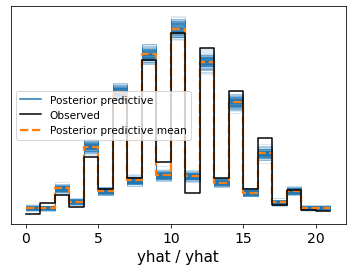

In [30]:
az.plot_ppc(az_bs_exp2_varyN, num_pp_samples=200)

In [31]:
az_bs_exp2_varyN.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.11801476, 0.3010551 , 0.58093014]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

In [32]:
az_bs_exp2_varyN.posterior.N_trial_sd.mean(axis=1)

<xarray.DataArray 'N_trial_sd' (chain: 1)>
array([0.40795865])
Coordinates:
  * chain    (chain) int64 0

<AxesSubplot:>

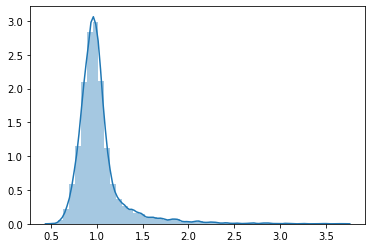

In [33]:
sns.distplot(np.exp(az_bs_exp2_varyN.posterior.N_trial.mean(axis=1).to_numpy()))

## PTN - Experiment 2

In [34]:
res_ptn_exp2 = fit_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(1e-3),
    n_steps = 6_000,
    full_rank = True,
    filename = "local/svi-ptn_simplecond_mlm_trial_level_disc-exp2.p"
)

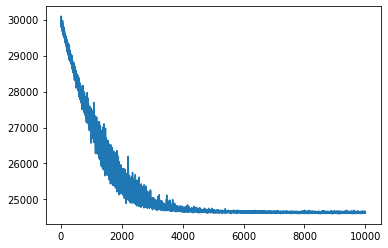

In [35]:
plt.plot(res_ptn_exp2["losses"])

In [36]:
az_ptn_exp2 = arviz_from_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    res_ptn_exp2["guide"], 
    res_ptn_exp2["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-ptn_simplecond_mlm_trial_level_disc-exp2svi.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

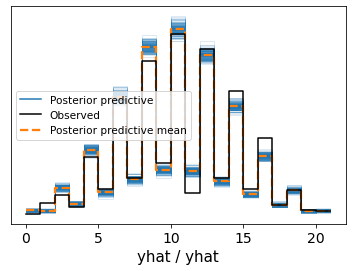

In [37]:
az.plot_ppc(az_ptn_exp2, num_pp_samples=200)

In [38]:
az_ptn_exp2.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.03961464, 0.37517272, 0.58521264]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

## K and K' model

In [7]:
res_ptn_exp2b = fit_svi(
    ptn_simplecond_mlm_trial_level_disc_kconjdisj, 
    X_exp2, 
    y_exp2,
    optimizer = Adam(1e-3),
    n_steps = 8_000,
    full_rank = True,
    filename = "local/svi-ptn_simplecond_mlm_trial_level_disc-exp2-kprime.p"
)

100%|██████████| 8000/8000 [28:46<00:00,  4.63it/s, init loss: 30114.8176, avg. loss [7601-8000]: 24719.2238]


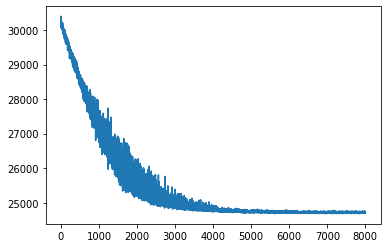

In [8]:
plt.plot(res_ptn_exp2b["losses"])

In [9]:
az_ptn_exp2b = arviz_from_svi(
    ptn_simplecond_mlm_trial_level_disc_kconjdisj, 
    res_ptn_exp2b["guide"], 
    res_ptn_exp2b["params"], 
    X_exp2, 
    obs_data=y_exp2,
    filename = "local/az-ptn_simplecond_mlm_trial_level_disc-exp2svi-kprime.p"
)

<AxesSubplot:xlabel='yhat / yhat'>

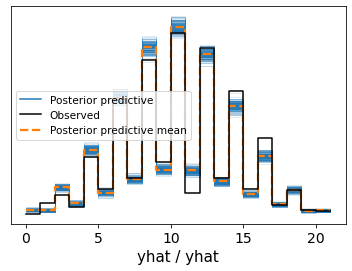

In [10]:
az.plot_ppc(az_ptn_exp2b, num_pp_samples=200)

In [11]:
az_ptn_exp2b.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.04592406, 0.36916053, 0.58491541]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

/home/dmpowell/.local/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/home/dmpowell/.local/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.
/home/dmpowell/.local/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_errorbarh : Removed 1 rows containing missing values.


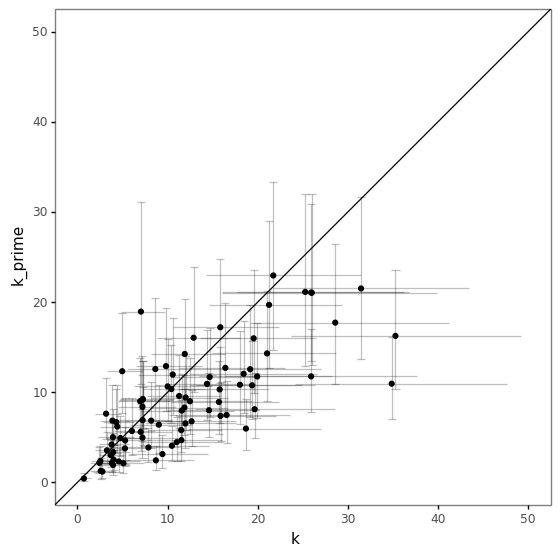

<ggplot: (2957287631438)>

In [25]:

posterior_ptn2b = posterior_to_df_mlm(
    az_ptn_exp2b, 
    ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"],
    ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj", "k", "k_prime"]
)

(
    posterior_ptn2b >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        kprime_est = _.k_prime.mean(),
        kprime_ll = _.k_prime.quantile(.05),
        kprime_ul = _.k_prime.quantile(.95)
    ) >>
    ggplot(aes(x="k_est", y="kprime_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="kprime_ll", ymax="kprime_ul"), width=0, alpha=.25) +
    geom_errorbarh(aes(xmin="k_ll", xmax="k_ul"), height=0, alpha=.25) +
#     geom_smooth(method="lm") +
    geom_abline(intercept=0, slope=1) +
    labs(y="k_prime", x="k") +
    theme_bw() +
    theme(aspect_ratio=1) +
    xlim(0,50) + ylim(0,50) +
    theme(panel_grid = element_blank())
)

Looks like k' values tend to be lower than k values, which is what Bayesian Sampler theory would predict. Could suggest there's some reason for connection between d and k. Not a problem for PT+N theory. I think not worth inclduing this.

In [39]:
az.compare({"bs": az_bs_exp2, "bs-varying": az_bs_exp2_varyN, "ptn":az_ptn_exp2})

/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated sha

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ptn,0,-24049.675593,554.263693,0.000000,0.73518,92.460462,0.000000,True,log
bs-varying,1,-24259.210289,1197.807875,209.534696,0.26482,95.818478,32.088307,True,log
bs,2,-25296.014723,1170.350022,1246.339130,0.00000,101.580937,56.502241,True,log


Allowing N to vary trial-by-trial improves things for BS. Reduces % of contaminants and improves elpd_loo. But still doing substantially worse than ptn. This would appear to be largely due to complexity? But % of contaminants for PT+N is still lower too.

# Model inspection

Some questions to investigate:

- In PT+N model: 
    - What proportion of responses are contaminants? 
        - (11% and 4% in exp 1, exp 2 - seem reasonable)
    - What are estimates of $k$? What are estimates of $d$ and $d'$? Are they in line with the avg-level estimates? with the theory? 
        - (as before, which in exp2 is too high per theory)
    - Are subject-level $k$ and $d$ correlated? BS says they should be 
        - (maybe in exp 1, no in exp 2)
    - Could refit another version allowing $k$ to vary between conj/disj trials and "normal" trials. <-- __do this__
- In BS model: 
    - what proportion of responses are contaminants? 
        - (47% and 25% in exp 1, exp2 --- far too high to be realisic)
    - What are estimtes of beta? What are estimates of N? Are they reasonable? 
        - (seem reasonable)
    - Are subject-level beta and N correlated? BS says they shouldn't be, would likely be a sign of misfit 
        - (they are not)
        
        
## NEW THINGS

Should try to do some stuff to rule out discrete versions of PT+N. Easiest thing would be look at Ps estimated to have low values of $k$ ($N$) and see how many of their actual responses are consistent with the limited set of respones possible under that or similar parameterizations for the discrete model (can also do this directly w/ variance rather than using model estimates maybe). My hunch is many of them won't be. Of course some would be allowable b/c that's just contaminants. 

And alternately, could be that on some trials they draw more samples than others, so wouldn't entirely rule out discrete versions but seems like a point against. In any case I think it starts to make it clear maybe?

- 3 (0, .33, .66, 1.0) --> {0, .3, .35, .65, .7, 1.)
- 4 (0, .25, .5, .75, 1) --> {0, .2, .25, .3, .5, .7, .75, .8, 1}
- 5 (0, .2, .4, .6, .8, 1) --> {0, .2, .4, .6, .8, 1}
- 6 (0, .166, .33, .5, .66, .833, 1.) --> {0, .15, .2, .3, .35, .5, .65, .7, .8, .85, 1}
- 7 (0, .14, .28, .43, .57, .71, .86, 1) --> {0, .1, .15, .3, .4, .45, .55, .6, .7, .85, .9, 1} 

so for $k$ between 1 and 6, the non-allowed responses are {.05, .1, .45, .55, .9, .95}. Between 1 and 7 just {.05, .95}.

So really pretty tough to make the case unless you're confident $k$ is less than 7.

### PT+N

__What are estimtes for $d$?__ At population-level, they are similar to prior estimates with averaged data. Per the theory's authors, they are higher than should be expected.

# Plots for paper

In [42]:
# az.plot_forest(data=az_ptn_exp2, var_names=["k"], combined=True)

posterior_ptn1 = posterior_to_df_mlm(
    az_ptn_exp1, 
    ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"],
    ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj", "k"]
)

posterior_ptn2 = posterior_to_df_mlm(
    az_ptn_exp2, 
    ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"],
    ["d_base_r", "d_delta_r", "d_subj", "d_prime_subj", "k"]
)

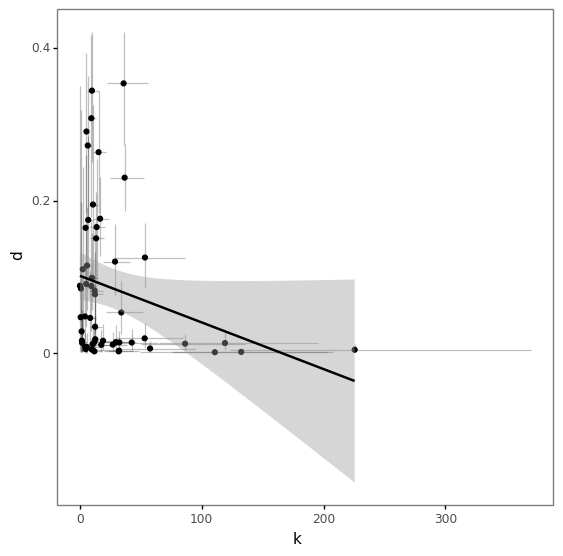

<ggplot: (-9223369066917485582)>

In [105]:
(
    posterior_ptn1 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
#     s.filter(_.k_est < 50.) >>
    s.filter(_.ID!=51, _.ID!=45, _.ID!=29, _.ID!=28) >>
    ggplot(aes(x="k_est", y="d_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="d_ll", ymax="d_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="k_ll", xmax="k_ul"), height=0, alpha=.25) +
    geom_smooth(method="lm") +
    labs(y="d", x="k") +
    theme_bw() +
    theme(aspect_ratio=1) +
    theme(panel_grid = element_blank())
)

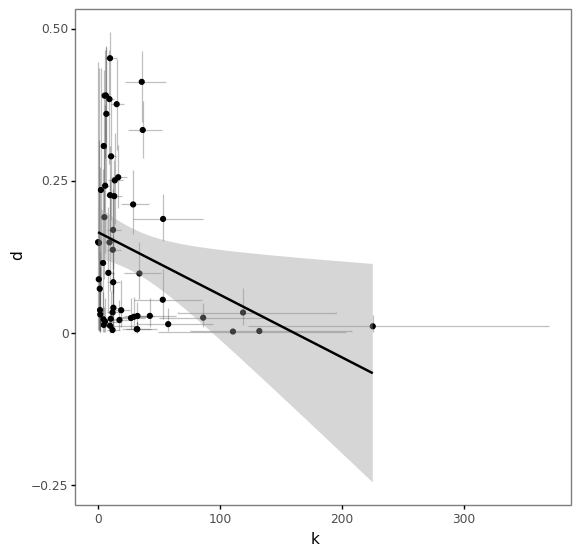

<ggplot: (-9223369066837427761)>

In [106]:
(
    posterior_ptn1 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_prime_subj.mean(),
        d_ll = _.d_prime_subj.quantile(.05),
        d_ul = _.d_prime_subj.quantile(.95)
    ) >>
#     s.filter(_.k_est < 50.) >>
    s.filter(_.ID!=51, _.ID!=45, _.ID!=29, _.ID!=28) >>
    ggplot(aes(x="k_est", y="d_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="d_ll", ymax="d_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="k_ll", xmax="k_ul"), height=0, alpha=.25) +
    geom_smooth(method="lm") +
    labs(y="d", x="k") +
    theme_bw() +
    theme(aspect_ratio=1) +
    theme(panel_grid = element_blank())
)

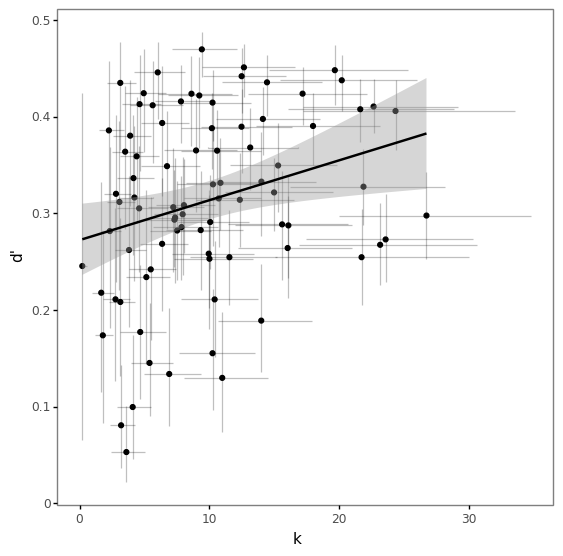

<ggplot: (-9223369066836995689)>

In [103]:
(
    posterior_ptn2 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_prime_subj.mean(),
        d_ll = _.d_prime_subj.quantile(.05),
        d_ul = _.d_prime_subj.quantile(.95)
    ) >>
    ggplot(aes(x="k_est", y="d_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="d_ll", ymax="d_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="k_ll", xmax="k_ul"), height=0, alpha=.25) +
    geom_smooth(method="lm") +
    labs(y="d'", x="k") +
    theme_bw() +
    theme(aspect_ratio=1) +
    theme(panel_grid = element_blank())
)

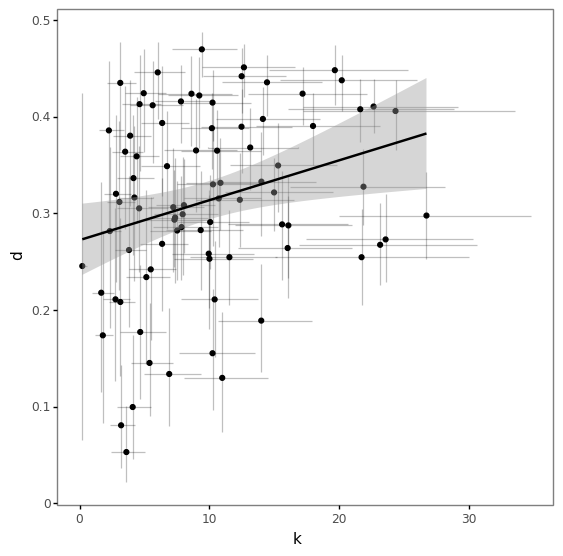

<ggplot: (-9223369066836811057)>

In [104]:
(
    posterior_ptn2 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_prime_subj.mean(),
        d_ll = _.d_prime_subj.quantile(.05),
        d_ul = _.d_prime_subj.quantile(.95)
    ) >>
    ggplot(aes(x="k_est", y="d_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="d_ll", ymax="d_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="k_ll", xmax="k_ul"), height=0, alpha=.25) +
    geom_smooth(method="lm") +
    labs(y="d", x="k") +
    theme_bw() +
    theme(aspect_ratio=1) +
    theme(panel_grid = element_blank())
)

In [46]:
exp1_model_comparison = az.compare({"BS": az_bs_exp1, "BS-varying": az_bs_exp1_varyN, "PT+N":az_ptn_exp1}, method="BB-pseudo-BMA")
exp2_model_comparison = az.compare({"BS": az_bs_exp2, "BS-varying": az_bs_exp2_varyN, "PT+N":az_ptn_exp2}, method="BB-pseudo-BMA")

exp1_model_comparison = exp1_model_comparison >> s.mutate(Experiment = "Exp. 1", model = exp1_model_comparison.index)
exp2_model_comparison = exp2_model_comparison >> s.mutate(Experiment = "Exp. 2", model = exp2_model_comparison.index)

model_comparison = exp1_model_comparison.append(exp2_model_comparison)

/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/home/dmpowell/.local/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated sha

In [61]:
table_output = (
    model_comparison >> 
    s.mutate(loo = np.round(_.loo,1), penalty = np.round(_.p_loo, 1)) >>
    s.select(_.Experiment, _.model, _.loo, _.penalty, _.d_loo, _.dse) #_.resp_r, _.trial_r)
)

table_output

,Experiment,model,loo,penalty,d_loo,dse
PT+N,Exp. 1,PT+N,-12406.4,566.5,0.000000,0.000000
BS-varying,Exp. 1,BS-varying,-13814.2,1117.7,1407.798747,65.544387
BS,Exp. 1,BS,-13917.9,999.1,1511.512140,71.650365
PT+N,Exp. 2,PT+N,-24049.7,554.3,0.000000,0.000000
BS-varying,Exp. 2,BS-varying,-24259.2,1197.8,209.534696,32.088307
BS,Exp. 2,BS,-25296.0,1170.4,1246.339130,56.502241


# Supplemental plots: PT+N model

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

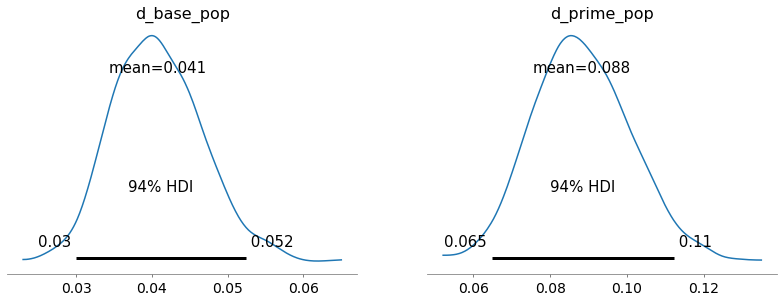

In [41]:
az_ptn_exp1.posterior["d_prime_pop"] = az_ptn_exp1.posterior.d_base_pop + np.exp(az_ptn_exp1.posterior.d_delta_pop)
az.plot_posterior(az_ptn_exp1, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

# az.plot_forest(data=az_ptn_exp1, var_names=["d_subj"], combined=True)

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

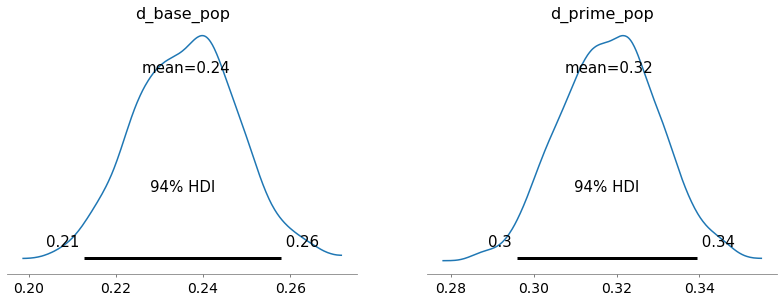

In [42]:
az_ptn_exp2.posterior["d_prime_pop"] = az_ptn_exp2.posterior.d_base_pop + np.exp(az_ptn_exp2.posterior.d_delta_pop)
az.plot_posterior(az_ptn_exp2, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

A couple more problematic response patterns:

- (nearly) always responding 50% (51, 45)
- (just about) only responding 0%, 50%, 100% (28, 45)
- (nearly) always responding 0 or 1 (29)
- just an excess of 0% 100% (maybe: 30, 32, 48, 14, 19, 18 -- bsically the rest of the high k Ps)

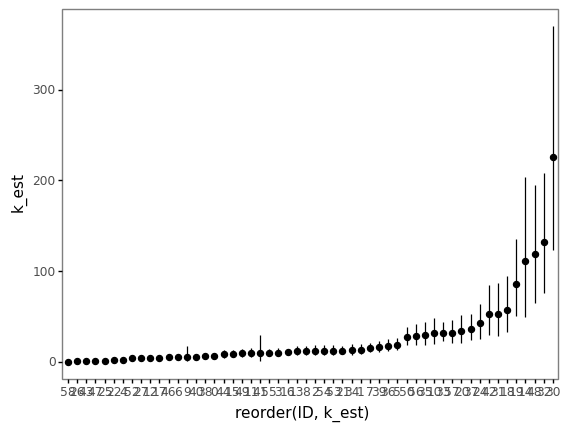

<ggplot: (2969935959272)>

In [89]:
(
    posterior_ptn1 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
#     s.filter(_.k_est > 50) >>
    s.filter(_.ID!=51, _.ID!=45, _.ID!=23, _.ID!=28, _.ID!=29) >>
    ggplot(aes(x="reorder(ID, k_est)", y="k_est", ymin="k_ll", ymax="k_ul")) +
    geom_pointrange() +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

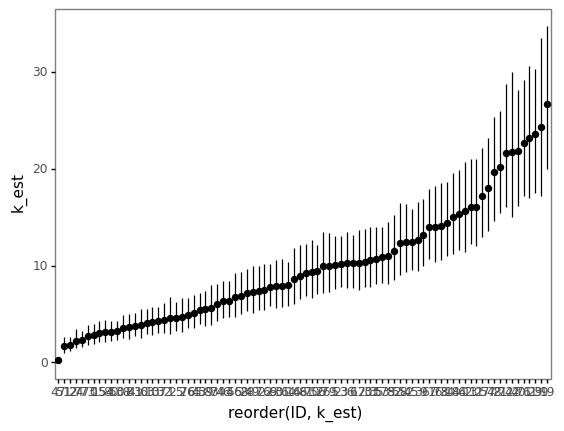

<ggplot: (-9223369066918614591)>

In [90]:
(
    posterior_ptn2 >>
    s.group_by(_.ID) >>
    s.summarize(
        k_est = _.k.mean(),
        k_ll = _.k.quantile(.05),
        k_ul = _.k.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
#     s.filter(_.k_est > 50) >>
#     s.filter(_.ID!=51, _.ID!=45, _.ID!=23, _.ID!=28, _.ID!=29) >>
    ggplot(aes(x="reorder(ID, k_est)", y="k_est", ymin="k_ll", ymax="k_ul")) +
    geom_pointrange() +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

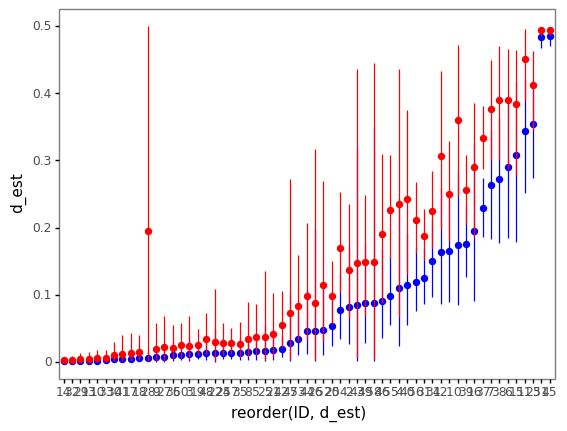

<ggplot: (-9223369066917171950)>

In [98]:
(
    posterior_ptn1 >>
    s.group_by(_.ID) >>
    s.summarize(
        dprime_est = _.d_prime_subj.mean(),
        dprime_ll = _.d_prime_subj.quantile(.05),
        dprime_ul = _.d_prime_subj.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
    ggplot() +
    geom_pointrange(aes(x="reorder(ID, d_est)", y="d_est", ymin="d_ll", ymax="d_ul"), color="blue") +
    geom_pointrange(aes(x="reorder(ID, d_est)", y="dprime_est", ymin="dprime_ll", ymax="dprime_ul"), color="red") +
    theme_bw() +
    theme(panel_grid = element_blank())
)

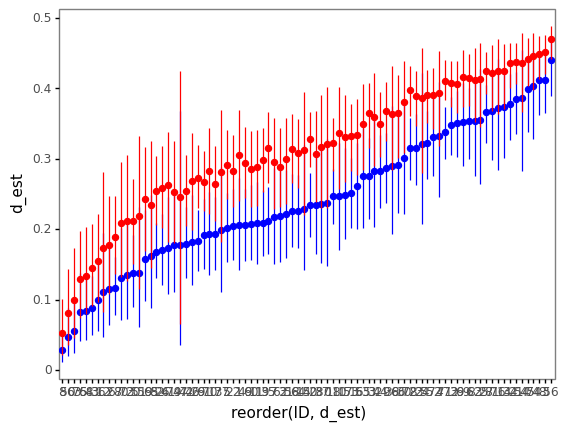

<ggplot: (-9223369066916795360)>

In [100]:
(
    posterior_ptn2 >>
    s.group_by(_.ID) >>
    s.summarize(
        dprime_est = _.d_prime_subj.mean(),
        dprime_ll = _.d_prime_subj.quantile(.05),
        dprime_ul = _.d_prime_subj.quantile(.95),
        d_est = _.d_subj.mean(),
        d_ll = _.d_subj.quantile(.05),
        d_ul = _.d_subj.quantile(.95)
    ) >>
    ggplot() +
    geom_pointrange(aes(x="reorder(ID, d_est)", y="d_est", ymin="d_ll", ymax="d_ul"), color="blue") +
    geom_pointrange(aes(x="reorder(ID, d_est)", y="dprime_est", ymin="dprime_ll", ymax="dprime_ul"), color="red") +
    theme_bw() +
    theme(panel_grid = element_blank())
)

# Supplemental plots BS model inspection

In [54]:
posterior_bs2 = posterior_to_df_mlm(
    az_bs_exp2, 
    ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd", "beta_pop", "beta_sd"],
    ["N_prime_r", "N_delta_r", "N_subj", "N_prime_subj", "beta_subj"]
)

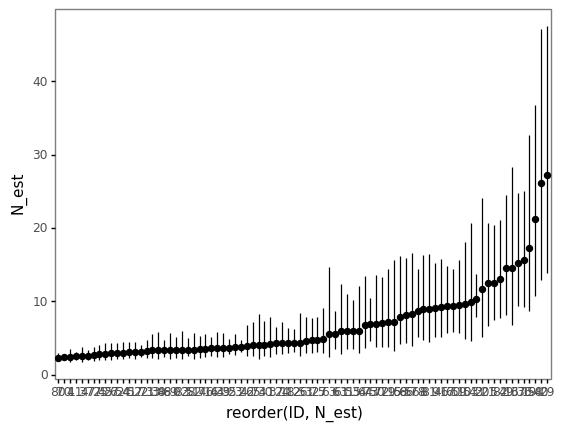

<ggplot: (-9223369075926145301)>

In [55]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_subj.mean(),
        N_ll = _.N_subj.quantile(.05),
        N_ul = _.N_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="reorder(ID, N_est)", y="N_est", ymin="N_ll", ymax="N_ul")) +
    geom_pointrange() +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

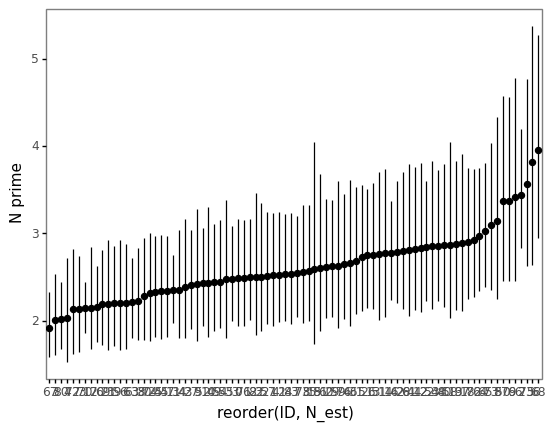

<ggplot: (-9223369075926145150)>

In [56]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_prime_subj.mean(),
        N_ll = _.N_prime_subj.quantile(.05),
        N_ul = _.N_prime_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="reorder(ID, N_est)", y="N_est", ymin="N_ll", ymax="N_ul")) +
    geom_pointrange() +
    labs(y="N prime") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

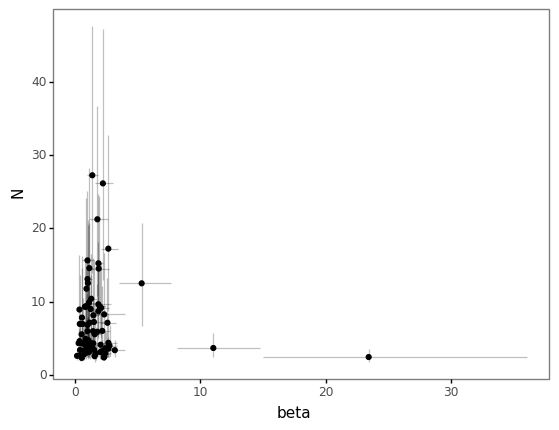

<ggplot: (-9223369075925869105)>

In [57]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_subj.mean(),
        N_ll = _.N_subj.quantile(.05),
        N_ul = _.N_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="beta_est", y="N_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="N_ll", ymax="N_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="beta_ll", xmax="beta_ul"), height=0., alpha=.25) +
#     geom_smooth(method="lm") +
    labs(y="N", x="beta") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

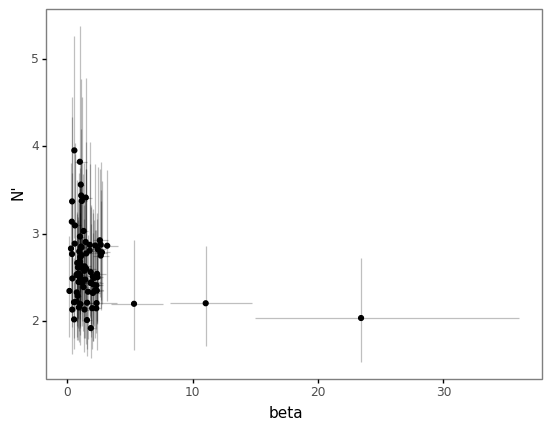

<ggplot: (-9223369075925572948)>

In [58]:
(
    posterior_bs2 >>
    s.group_by(_.ID) >>
    s.summarize(
        N_est = _.N_prime_subj.mean(),
        N_ll = _.N_prime_subj.quantile(.05),
        N_ul = _.N_prime_subj.quantile(.95),
        beta_est = _.beta_subj.mean(),
        beta_ll = _.beta_subj.quantile(.05),
        beta_ul = _.beta_subj.quantile(.95)
    ) >>
    ggplot(aes(x="beta_est", y="N_est")) +
    geom_point() +
    geom_errorbar(aes(ymin="N_ll", ymax="N_ul"), width=0., alpha=.25) +
    geom_errorbarh(aes(xmin="beta_ll", xmax="beta_ul"), height=0., alpha=.25) +
#     geom_smooth(method="lm") +
    labs(y="N'", x="beta") +
#     xlim(0,8) +
    theme_bw() +
    theme(panel_grid = element_blank())
)

# Supplemental plots: Pairs plots

array([[<AxesSubplot:ylabel='d_delta_pop'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='d_base_sd'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='d_base_pop', ylabel='d_delta_sd'>,
        <AxesSubplot:xlabel='d_delta_pop'>,
        <AxesSubplot:xlabel='d_base_sd'>]], dtype=object)

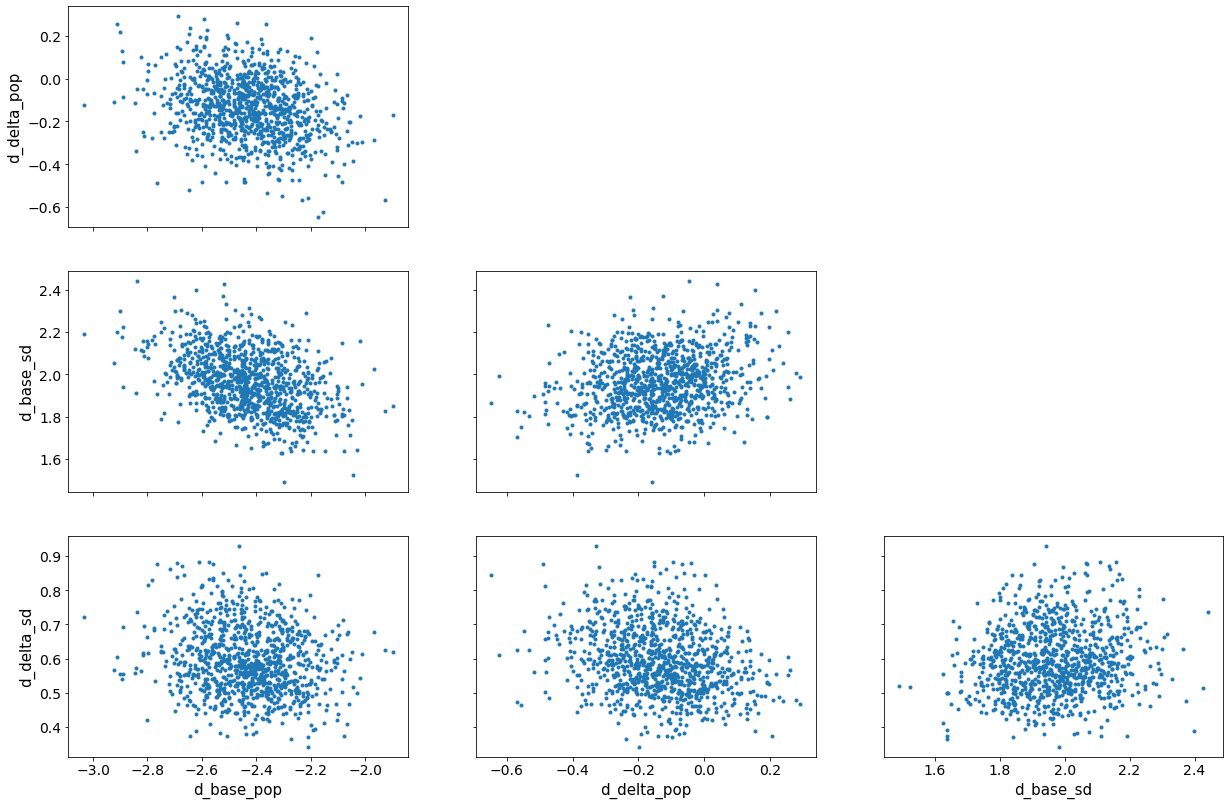

In [88]:
# posterior_ptn2b = dist_to_df(
#     az_ptn_exp2, 
#     ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"]
# )
# posterior_ptn2b
az.plot_pair(az_ptn_exp1, var_names = ["d_base_pop","d_delta_pop","d_base_sd", "d_delta_sd"])

array([[<AxesSubplot:ylabel='d_delta_pop'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='d_base_sd'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='d_base_pop', ylabel='d_delta_sd'>,
        <AxesSubplot:xlabel='d_delta_pop'>,
        <AxesSubplot:xlabel='d_base_sd'>]], dtype=object)

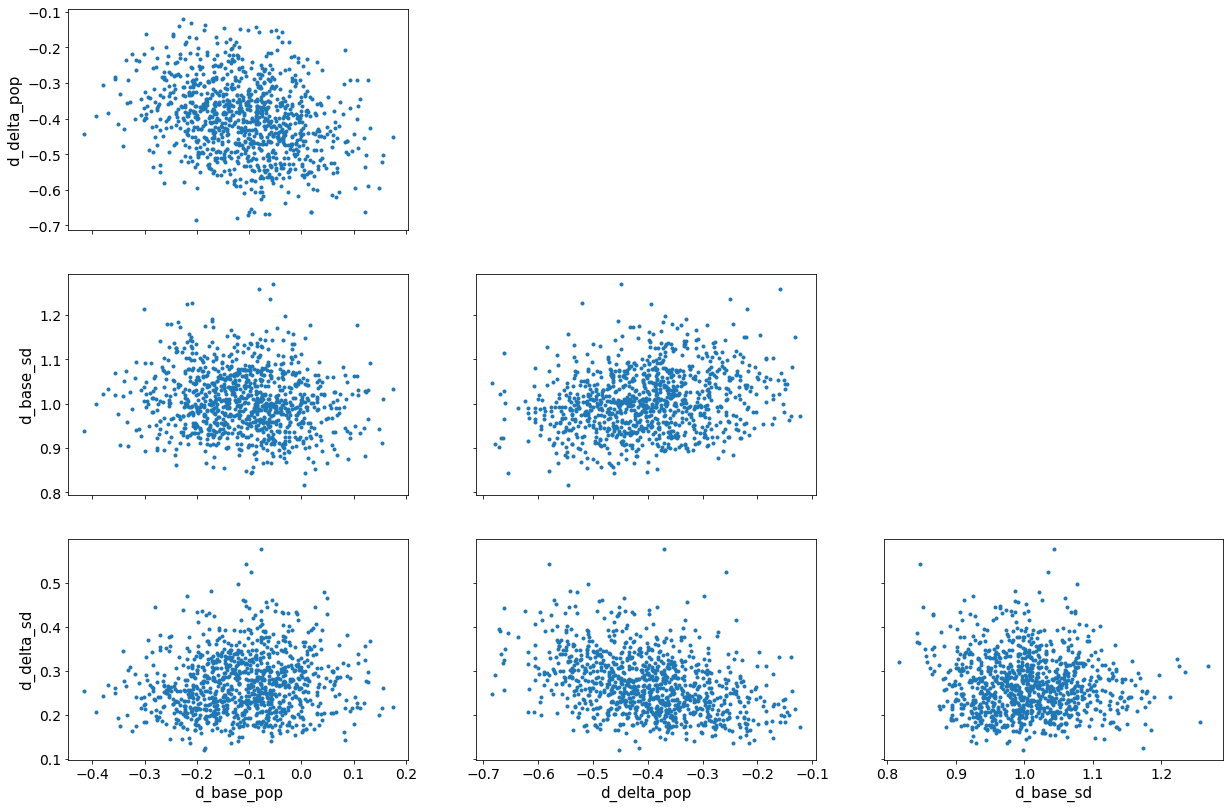

In [87]:
az.plot_pair(az_ptn_exp2, var_names = ["d_base_pop","d_delta_pop","d_base_sd","d_delta_sd"])

array([[<AxesSubplot:ylabel='N_delta_pop'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='N_prime_sd'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='N_prime_pop', ylabel='N_delta_sd'>,
        <AxesSubplot:xlabel='N_delta_pop'>,
        <AxesSubplot:xlabel='N_prime_sd'>]], dtype=object)

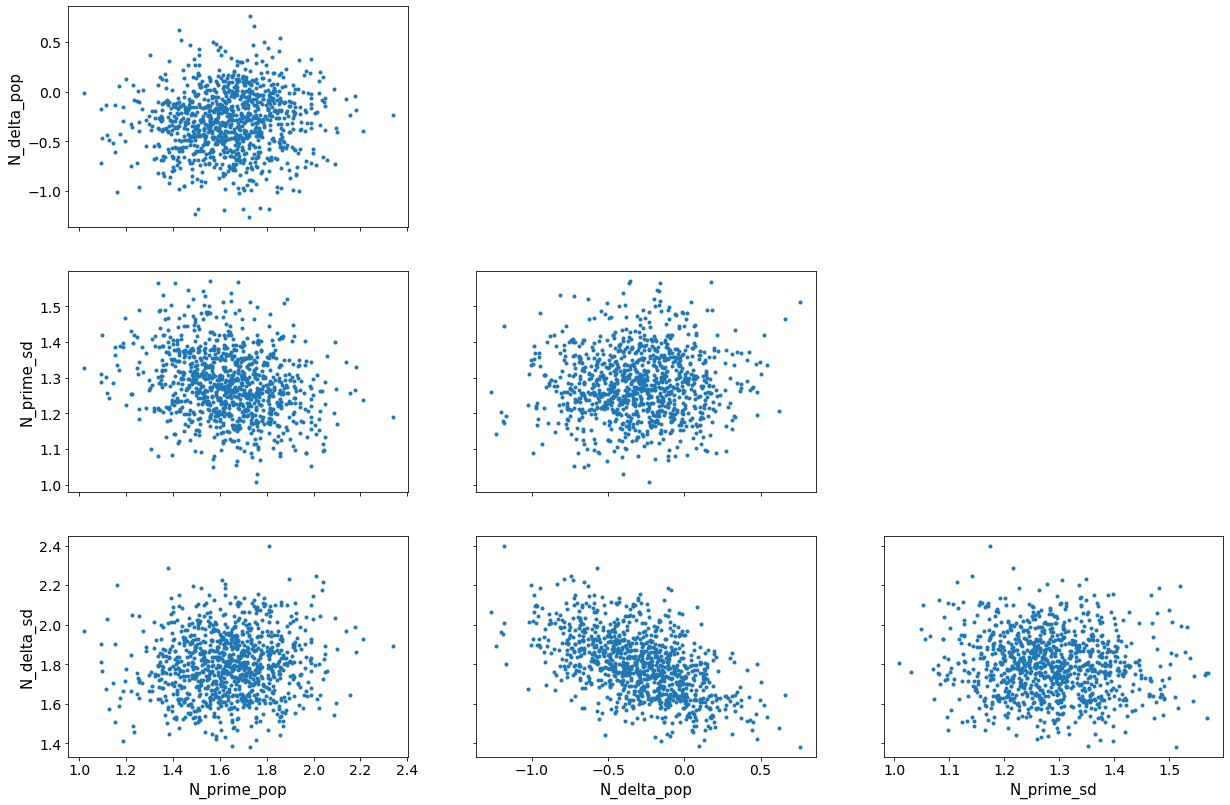

In [70]:
az.plot_pair(az_bs_exp1, var_names = ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd"])

array([[<AxesSubplot:ylabel='N_delta_pop'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='N_prime_sd'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='N_prime_pop', ylabel='N_delta_sd'>,
        <AxesSubplot:xlabel='N_delta_pop'>,
        <AxesSubplot:xlabel='N_prime_sd'>]], dtype=object)

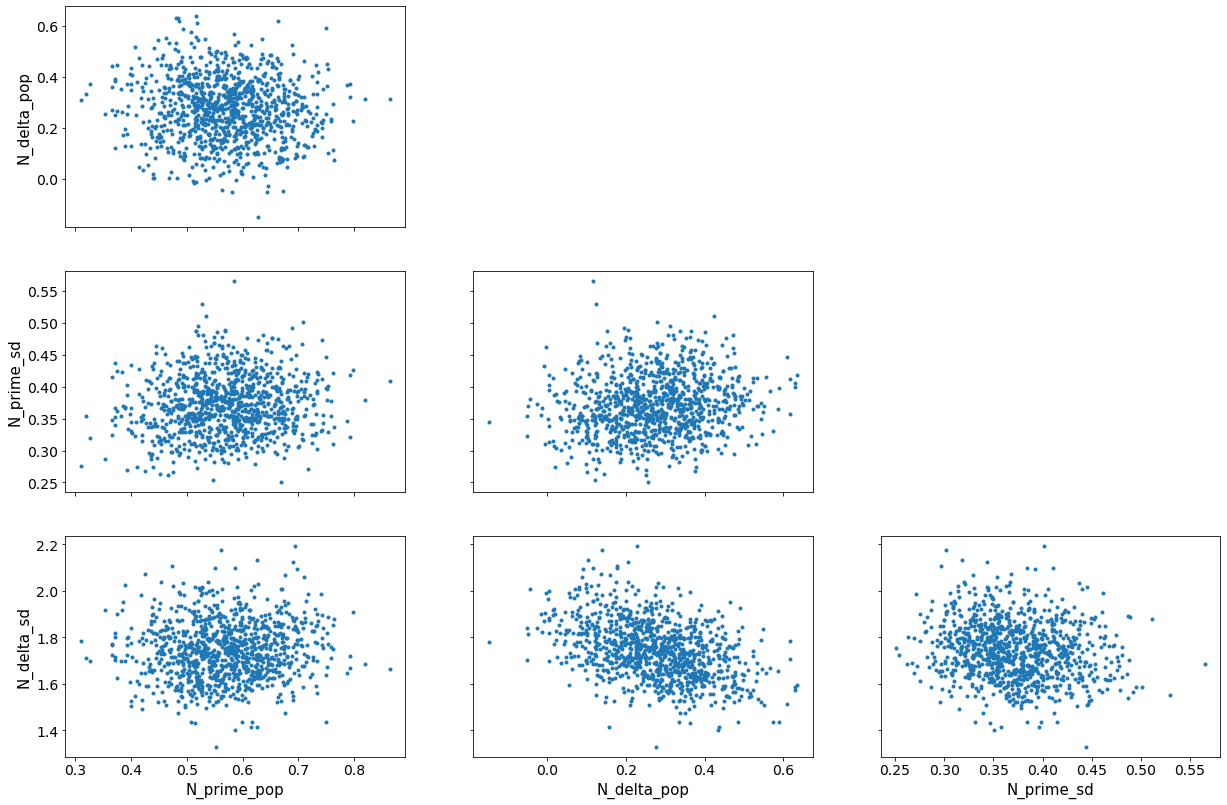

In [86]:
az.plot_pair(az_bs_exp2, var_names = ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd"])